In [0]:
!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:

json_import = drive.CreateFile({'id':'1qaWXROHLpMwBPGDekqu7Y-SekGdbkejX'})
json_import.GetContentFile('tokens.pkl')

glovefile = drive.CreateFile({'id':'1-b4gcZ6037es4umLTaRCnHb6vdPsAej4'})
glovefile.GetContentFile('glove100d.txt')

vocabembed = drive.CreateFile({'id':'14ECduHc-jveJFPalm5Npmcis7vj-CqxQ'}) #14ECduHc-jveJFPalm5Npmcis7vj-CqxQ
vocabembed.GetContentFile('vocabulary-embedding.pkl')

vocabembeddata = drive.CreateFile({'id':'1UJEkEt_9DoHcWb3RRzwlY4SQR1ZovScs'})
vocabembeddata.GetContentFile('vocabulary-embedding.data.pkl')

Generate intial word embedding for headlines and description

The embedding is limited to a fixed vocabulary size (`vocab_size`) but
a vocabulary of all the words that appeared in the data is built.

In [0]:
FN = 'vocabulary-embedding'

In [0]:
seed=42

In [0]:
vocab_size = 40000

In [0]:
embedding_dim = 100

In [0]:
lower = False # dont lower case the text

# read tokenized headlines and descriptions

In [0]:
import pickle
FN0 = 'tokens' 
with open('tokens.pkl', 'rb') as fp:
    heads, desc, keywords = pickle.load(fp) 

In [0]:
if lower:
    heads = [h.lower() for h in heads]

In [0]:
if lower:
    desc = [h.lower() for h in desc]

In [36]:
i=0
heads[i]

'Worcester breakfast club for veterans gives hunger its marching orders'

In [0]:
for i in range(len(desc)):
    desc[i]=' '.join(desc[i])

In [38]:
desc[0]

'VETERANS saluted Worcester\'s first ever breakfast club for ex-soldiers which won over hearts, minds and bellies.  The Worcester Breakfast Club for HM Forces Veterans met at the Postal Order in Foregate Street at 10am on Saturday.  The club is designed to allow veterans a place to meet, socialise, eat and drink, giving hunger and loneliness their marching orders.  Father-of-two Dave Carney, aged 43, of Merrimans Hill, Worcester, set up the club after being inspired by other similar clubs across the country.  He said: "As you can see from the picture, we had a good response. Five out of the 10 that attended said they saw the article in the newspaper and turned up.  "We even had an old chap travel from Droitwich and he was late on parade by three hours.  "It\'s generated a lot of interest and I estimate (from other veterans who saw the article) that next month\'s meeting will attract about 20 people. Onwards and upwards."  He said the management at the pub had been extremely hospitable 

In [39]:
len(heads),len(set(heads))

(1000, 999)

# build vocabulary

In [0]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    vocab=list(vocab) 
    return vocab, vocabcount

In [0]:
vocab, vocabcount = get_vocab(heads+desc)

most popular tokens

In [42]:
print(vocab[:50])
print('...',len(vocab))

['the', 'to', 'and', 'of', 'a', 'in', 'for', 'is', 'on', 'that', 'with', 'The', 'at', 'was', 'as', 'be', 'are', 'from', 'by', 'have', 'it', 'will', 'I', 'has', 'this', 'an', 'you', 'or', 'not', 'their', 'he', 'his', 'more', 'but', 'said', 'we', 'who', 'they', 'can', 'its', 'been', 'which', 'about', 'your', 'our', 'all', '-', 'were', 'also', 'out']
... 62818


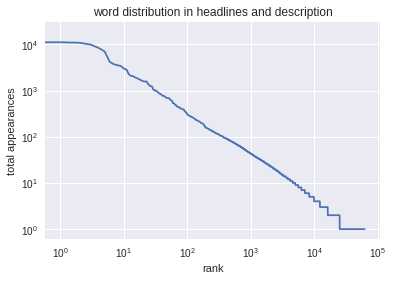

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and description')
plt.xlabel('rank')
plt.ylabel('total appearances');

Zipf's law states that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table.

# Index words

In [0]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [0]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [0]:
word2idx, idx2word = get_idx(vocab, vocabcount)

# Word Embedding

## read GloVe

In [47]:
glove_name ="glove100d.txt"
glove_n_symbols = !wc -l {glove_name}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

400000

In [0]:
import numpy as np
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        for j in range(len(glove_embedding_weights[i,:])):  
          glove_embedding_weights[i,j] = l[j+1]
        i += 1
glove_embedding_weights *= globale_scale

In [49]:
glove_embedding_weights.std()

0.04081572760019029

In [0]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

## embedding matrix

use GloVe to initialize embedding matrix

In [51]:

# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print ('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

random-embedding/glove scale 0.0706949139514209 std 0.04081382495746382
number of tokens, in small vocab, found in glove and copied to embedding 22496 0.5624


lots of word in the full vocabulary (word2idx) are outside `vocab_size`.
Build an alterantive which will map them to their closest match in glove but only if the match
is good enough (cos distance above `glove_thr`)

In [0]:
glove_thr = 0.5

In [0]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

for every word outside the embedding matrix find the closest word inside the mebedding matrix.
Use cos distance of GloVe vectors.

Allow for the last `nb_unknown_words` words inside the embedding matrix to be considered to be outside.
Dont accept distances below `glove_thr`

In [54]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.items():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print ('# of glove substitutes found', len(glove_match))

# of glove substitutes found 6482


manually check that the worst substitutions we are going to do are good enough



In [55]:
for orig, sub, score in glove_match[-10:]:
    print (score, orig,'=>', idx2word[sub])

0.5011183604640216 McCaffery => Capelli
0.5011098354624549 patched => tweak
0.5010184307250274 Claver => Namal
0.5009483763639891 Beimel => Braden
0.5009247040305201 Tobin => Cullen
0.5009036550525888 Gera => Vanessa
0.5006593974683046 Cowart => Shumpert
0.5006021079172154 Ark => Noah
0.5004490461650744 shadowing => moonlighting
0.5000050436924418 Yellowjacket => ranter


build a lookup table of index of outside words to index of inside words

In [0]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

# Distribution of Data

In [57]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]
len(Y)

1000

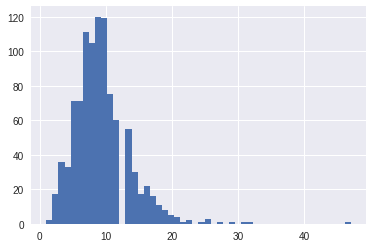

In [58]:
plt.hist(list(map(len,Y)),bins=50);

In [59]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)

1000

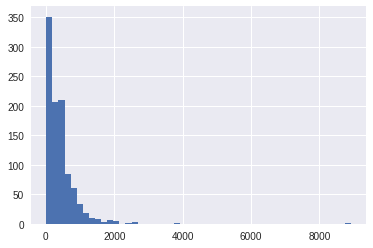

In [60]:
plt.hist(list(map(len,X)),bins=50);

In [0]:
import pickle
import os
with open('%s.pkl'%FN,'wb') as fp1:
    #print(os.path.getsize('%s.pkl'%FN))
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp1,-1)
    #print(os.path.getsize('%s.pkl'%FN))
    
vocabembed.SetContentFile('%s.pkl'%FN)
vocabembed.Upload()

In [0]:
with open('%s.data.pkl'%FN,'wb') as fp2:
    pickle.dump((X,Y),fp2,-1)

vocabembeddata.SetContentFile('%s.data.pkl'%FN)
vocabembeddata.Upload()